In [20]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
#import ngauge
#from ngauge import Neuron
from skimage.io import*
from skimage.morphology import binary_dilation, ball,cube
import mat73
import tifffile as tiff 
from skimage.color import label2rgb
from tqdm.notebook import tqdm
import warnings; warnings.simplefilter('ignore')
#import neurom 
sns.set_context('paper')
sns.set_style('ticks')
#plt.style.use("dark_background")
#matplotlib.use('TkAgg')

In [19]:
#SWC: with dilation
# For processing the SWC generated from Imaris
def read_swc(file_path):
    """Read coordinates and radii from an SWC file."""
    swc_data = pd.read_csv(file_path, delim_whitespace=True, comment='#', 
                           names=['n', 'type', 'x', 'y', 'z', 'r', 'parent'])
    print(f'Swc file {file_path} has {swc_data.shape[0]} rows and {swc_data.shape[1]} columns')
    return swc_data[['x', 'y', 'z']].values, swc_data['r'].values# pr

def add_to_binary_image(binary_image, coordinates, radii):
    """Mark points in the binary image based on coordinates and dilate them with specific radii."""
    for (x, y, z), radius in zip(coordinates, radii):
        x = x*0.0578000 #pixel size
        y = y*0.0578000
        z = z*0.1300000
        if 0 <= x < binary_image.shape[2] and 0 <= y < binary_image.shape[1] and 0 <= z < binary_image.shape[0]:
            # Adjust the dilation size based on the radius, ensuring it is at least 1
            dilation_size = max(1, int(radius/2))
            dilation_size = dilation_size + 10
            selem = cube(dilation_size)
            # Calculate the region to apply dilation
            z_min, z_max = max(0, int(z) - dilation_size), min(binary_image.shape[0], int(z) + dilation_size + 1)
            y_min, y_max = max(0, int(y) - dilation_size), min(binary_image.shape[1], int(y) + dilation_size + 1)
            x_min, x_max = max(0, int(x) - dilation_size), min(binary_image.shape[2], int(x) + dilation_size + 1)
            # Apply dilation only within the specified region to save computation
            binary_image[z_min:z_max, y_min:y_max, x_min:x_max] |= binary_dilation(binary_image[z_min:z_max, y_min:y_max, x_min:x_max] == 0, selem)
            #apply dilation to the whole image
            #binary_image |= binary_dilation(binary_image == 0, selem)
    return binary_image

def create_3d_binary_image(swc_files, image_size):
    """Create a 3D binary image from multiple SWC files, dilating based on point-specific radii."""
    binary_image = np.zeros(image_size, dtype=np.uint8)
    for file_path in swc_files:
        coordinates, radii = read_swc(file_path)
        add_to_binary_image(binary_image, coordinates, radii)
    return binary_image

In [3]:
## MAT: with dilation
# For processing MAT files
def process_mat(mat_file):
    mat_data = mat73.loadmat(mat_file)
    efpxTrace = mat_data['efPxTrace']
    points = efpxTrace['Points']
    diamters = efpxTrace['Diameter']
    return points, diamters

def mat_df(mat_file):
    points, diamters = process_mat(mat_file)
    points = np.concatenate(points)
    radius = []
    for i in range(len(diamters)):
        radius.append(diamters[i]/2)
    radius = np.concatenate(radius)
    df = pd.DataFrame(points, columns=['x', 'y', 'z'])
    df['r'] = radius
    return df

def create_mat_binary_image(mat_file, image_size):
    """Create a 3D binary image from a mat file, dilating based on point-specific radii."""
    binary_image = np.zeros(image_size, dtype=np.uint8)
    df = mat_df(mat_file)
    coordinates = df[['x', 'y', 'z']].values
    radii = df['r'].values
    add_to_binary_image(binary_image, coordinates, radii)
    return binary_image

In [32]:
def get_neuron(mat_file,cellid:str):
    mat_file = mat73.loadmat(mat_file)
    efpxTrace = mat_file['efPxTrace']
    efpxTrace = pd.DataFrame.from_dict(efpxTrace)
    neuron = efpxTrace[efpxTrace['SetId'] == cellid]
    points = neuron['Points']
    points = np.array(points)
    points = np.concatenate(points)
    radius = neuron['Diameter']
    radius = np.array(radius)/2
    radius = np.concatenate(radius)
    return points, radius

In [9]:
def iou(pred, gt):
    intersection = np.logical_and(pred, gt)
    union = np.logical_or(pred, gt)
    iou_score = np.sum(intersection) / np.sum(union)
    return intersection, union, iou_score

In [61]:
def crop_img(bin_img,bbox=None):
    if bbox is None:
        #crete a bounding box
        z,y,x = np.where(bin_img>0)
        x_min,x_max = x.min(),x.max()
        y_min,y_max = y.min(),y.max()
        z_min,z_max = z.min(),z.max()
        #add perturbation to the bounding box
        z_sz,y_sz,x_sz = bin_img.shape
        x_min = max(0,x_min-np.random.randint(0,20))
        x_max = min(x_sz,x_max+np.random.randint(0,20))
        y_min = max(0,y_min-np.random.randint(0,20))
        y_max = min(y_sz,y_max+np.random.randint(0,20))
        z_min = max(0,z_min-np.random.randint(0,20))
        z_max = min(z_sz,z_max+np.random.randint(0,20))
        bbox = (z_min,z_max,y_min,y_max,x_min,x_max)
        bbox = np.array(bbox)
        z_min,z_max,y_min,y_max,x_min,x_max = bbox
    else:
        z_min,z_max,y_min,y_max,x_min,x_max = bbox
    return bin_img[z_min:z_max,y_min:y_max,x_min:x_max],bbox

In [5]:
img_size = (97, 2844, 2835) # real image size 

In [ ]:
neuron_ids = pd.read_excel('ImarisAutotrace_NeuronID.xlsx') #get the neuron ids
neuron_ids.head()

In [11]:
auto_trace_ids = neuron_ids['Imaris autotrace'].values
neurons = neuron_ids['Neuron#'].values

#add 'Cell ' to the neuron ids
neurons = ['Cell ' + str(i) for i in neurons]
print(neurons)


['Cell 32', 'Cell 14', 'Cell 20', 'Cell 22', 'Cell 19', 'Cell 18', 'Cell 10', 'Cell 29', 'Cell 30', 'Cell 26', 'Cell 24', 'Cell 15', 'Cell 1', 'Cell 23', 'Cell 34', 'Cell 16', 'Cell 28', 'Cell 33', 'Cell 4', 'Cell 36']


In [13]:
print(auto_trace_ids)

['auto_trace.swc_filament_0.swc' 'auto_trace.swc_filament_1.swc'
 'auto_trace.swc_filament_2.swc' 'auto_trace.swc_filament_3.swc'
 'auto_trace.swc_filament_4.swc' 'auto_trace.swc_filament_5.swc'
 'auto_trace.swc_filament_6.swc' 'auto_trace.swc_filament_7.swc'
 'auto_trace.swc_filament_8.swc' 'auto_trace.swc_filament_9.swc'
 'auto_trace.swc_filament_10.swc' 'auto_trace.swc_filament_11.swc'
 'auto_trace.swc_filament_12.swc' 'auto_trace.swc_filament_13.swc'
 'auto_trace.swc_filament_14.swc' 'auto_trace.swc_filament_15.swc'
 'auto_trace.swc_filament_16.swc' 'auto_trace.swc_filament_17.swc'
 'auto_trace.swc_filament_18.swc' 'auto_trace.swc_filament_20.swc']


In [ ]:
single_autotraces = {}
for n in tqdm(range(len(auto_trace_ids))):
    cell_id = auto_trace_ids[n]
    traces = create_3d_binary_image([f'auto-trace/{cell_id}'], img_size)
    single_autotraces[neurons[n]] = traces

In [ ]:
single_gt = {}
for n in tqdm(range(len(neurons))):
    cell_id = neurons[n]
    points,radii = get_neuron('ProcessedTraces_Manual.mat', cell_id)
    traces = add_to_binary_image(np.zeros(img_size, dtype=np.uint8), points, radii)
    single_gt[cell_id] = traces

In [ ]:
single_qdye = {}
for n in tqdm(range(len(neurons))):
    cell_id = neurons[n]
    points,radii = get_neuron('AfterClustering.mat', cell_id)
    traces = add_to_binary_image(np.zeros(img_size, dtype=np.uint8), points, radii)
    single_qdye[cell_id] = traces

In [ ]:
gt_crops = {}
qdye_crops = {}
imaris_crops = {}
for n in tqdm(range(len(neurons))):
    cell_id = neurons[n]
    gt = single_gt[cell_id]
    qdye = single_qdye[cell_id]
    imaris = single_autotraces[cell_id]
    gt_crop,bbox = crop_img(gt)
    qdye_crop,_ = crop_img(qdye,bbox=bbox)
    imaris_crop,_ = crop_img(imaris,bbox=bbox)
    gt_crops[cell_id] = gt_crop
    qdye_crops[cell_id] = qdye_crop
    imaris_crops[cell_id] = imaris_crop

In [70]:
qdye_crops['Cell 4'].shape

(97, 749, 994)

In [74]:
#plot all the single gt
len(single_gt)

20

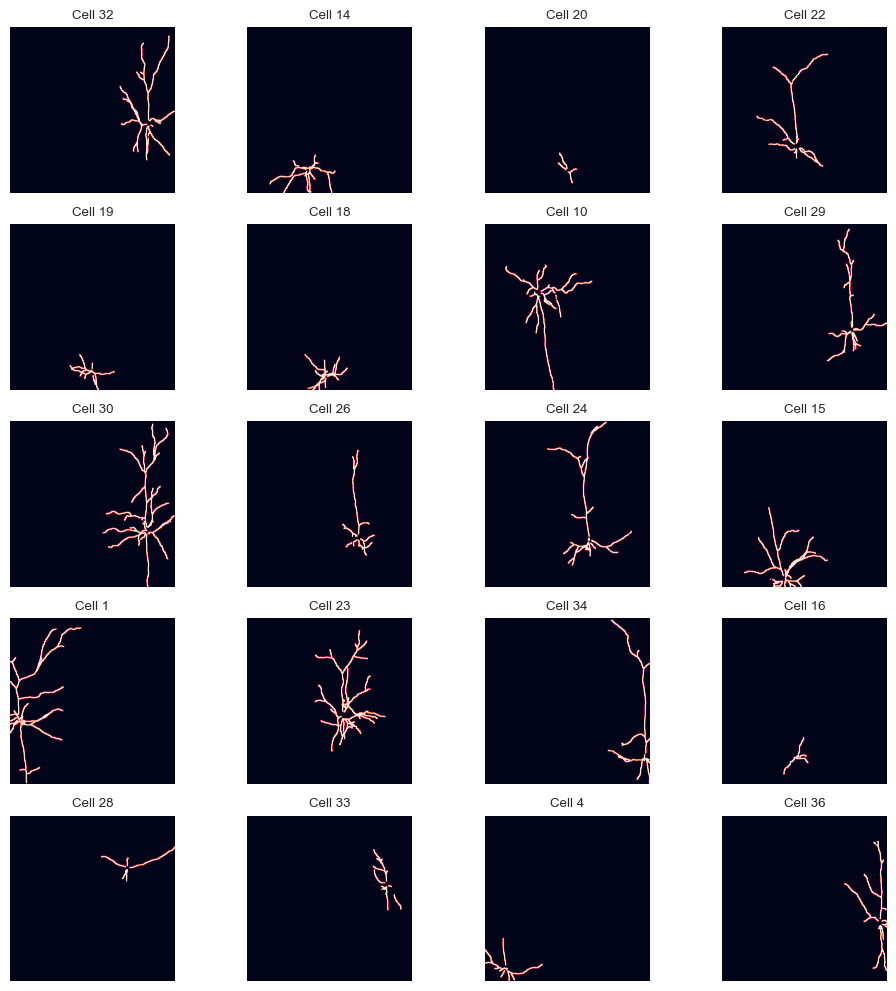

In [78]:
fig,ax = plt.subplots(5,4,figsize=(10,10))
for i,(k,v) in enumerate(single_gt.items()):
    ax[i//4,i%4].imshow(v.max(axis=0))
    ax[i//4,i%4].set_title(k)
    ax[i//4,i%4].axis('off')
plt.tight_layout()
plt.show();

In [ ]:
imaris_gt_intersection = {}

for n in tqdm(range(len(neurons)), desc='Calculating Intersection...'):
    cell_id = neurons[n]
    pred = single_autotraces[cell_id]
    gt = single_gt[cell_id]
    intersection, union, iou_score = iou(pred, gt)
    imaris_gt_intersection[cell_id] = intersection 

In [38]:
perc_overlap_imaris_gt = {}
for n in range(len(neurons)):
    cell_id = neurons[n]
    intersection = imaris_gt_intersection[cell_id]
    gt = single_gt[cell_id]
    perc_overlap_imaris_gt[cell_id] = np.sum(intersection)/np.sum(gt)

In [ ]:
qdye_gt_intersection = {}   
for n in tqdm(range(len(neurons)), desc='Calculating Intersection...'):
    cell_id = neurons[n]
    pred = single_qdye[cell_id]
    gt = single_gt[cell_id]
    intersection, union, iou_score = iou(pred, gt)
    qdye_gt_intersection[cell_id] = intersection

In [48]:
perc_overlap_qdye_gt = {}
for n in range(len(neurons)):
    cell_id = neurons[n]
    intersection = qdye_gt_intersection[cell_id]
    gt = single_gt[cell_id]
    perc_overlap_qdye_gt[cell_id] = np.sum(intersection)/np.sum(gt)  

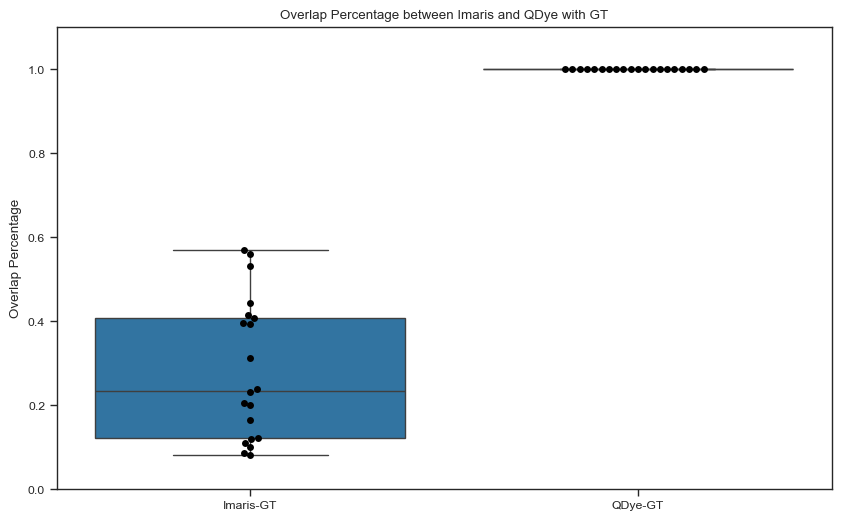

In [58]:
#plot boxplot with the groups - Imaris-Gt and QDye-Gt and the overlap percentage on the y-axis, and the x-axis as the groups, there should be datapoints showing each neuron
#plot the boxplot for the two groups
fig = plt.figure(figsize=(10, 6))
data = [list(perc_overlap_imaris_gt.values()), list(perc_overlap_qdye_gt.values())]
sns.boxplot(data=data, showfliers=True)
sns.swarmplot(data=data, color='black', size=5)
plt.ylim(0, 1.1)
plt.ylabel('Overlap Percentage')
plt.xticks([0, 1], ['Imaris-GT', 'QDye-GT'])

plt.title('Overlap Percentage between Imaris and QDye with GT')
plt.show();

In [79]:
##process gt
## MAT: with dilation
# For processing MAT files
def process_converted_mat(mat_file):
    mat_data = mat73.loadmat(mat_file)
    efpxTrace = mat_data['ans']
    points = efpxTrace['Points']
    diamters = efpxTrace['Diameter']
    return points, diamters

def mat_converted_df(mat_file):
    points, diamters = process_mat(mat_file)
    points = np.concatenate(points)
    radius = []
    for i in range(len(diamters)):
        radius.append(diamters[i]/2)
    radius = np.concatenate(radius)
    df = pd.DataFrame(points, columns=['x', 'y', 'z'])
    #make the coordinates positive
    df['x'] = np.abs(df['x'])
    df['y'] = np.abs(df['y'])
    df['z'] = np.abs(df['z'])

    #scale the coordinates
    df['x'] = df['x']/0.180
    df['y'] = df['y']/0.180
    df['z'] = df['z']/0.500 # in microns
    df['r'] = radius
    return df

def create_mat_cvt_binary_image(mat_file, image_size):
    """Create a 3D binary image from a mat file, dilating based on point-specific radii."""
    binary_image = np.zeros(image_size, dtype=np.uint8)
    df = mat_df(mat_file)
    coordinates = df[['x', 'y', 'z']].values
    radii = df['r'].values
    add_to_binary_image(binary_image, coordinates, radii)
    return binary_image

In [85]:
def get_cvt_neuron(mat_file,cellid:str):
    mat_file = mat73.loadmat(mat_file)
    efpxTrace = mat_file['ans']
    efpxTrace = pd.DataFrame.from_dict(efpxTrace)
    neuron = efpxTrace[efpxTrace['SetId'] == cellid]
    points = neuron['Points']
    points = np.array(points)
    #make the coordinates positive
    points = np.abs(points)
    points = np.concatenate(points)
    radius = neuron['Diameter']
    radius = np.array(radius)/2
    radius = np.concatenate(radius)
    return points, radius

In [83]:
def add_to_binary_image_cvt(binary_image, coordinates, radii):
    """Mark points in the binary image based on coordinates and dilate them with specific radii."""
    for (x, y, z), radius in zip(coordinates, radii):
        #scale the coordinates
        x = x/0.180
        y = y/0.180
        z = z/0.500 # in microns
        if 0 <= x < binary_image.shape[2] and 0 <= y < binary_image.shape[1] and 0 <= z < binary_image.shape[0]:
            # Adjust the dilation size based on the radius, ensuring it is at least 1
            dilation_size = max(1, int(radius/2))
            #add 10 to the radius
            dilation_size = dilation_size + 10
            selem = cube(dilation_size)
            # Calculate the region to apply dilation
            z_min, z_max = max(0, int(z) - dilation_size), min(binary_image.shape[0], int(z) + dilation_size + 1)
            y_min, y_max = max(0, int(y) - dilation_size), min(binary_image.shape[1], int(y) + dilation_size + 1)
            x_min, x_max = max(0, int(x) - dilation_size), min(binary_image.shape[2], int(x) + dilation_size + 1)
            # Apply dilation only within the specified region to save computation
            binary_image[z_min:z_max, y_min:y_max, x_min:x_max] |= binary_dilation(binary_image[z_min:z_max, y_min:y_max, x_min:x_max] == 0, selem)
            #apply dilation to the whole image
            #binary_image |= binary_dilation(binary_image == 0, selem)
    return binary_image

In [132]:
single_gt_cvt = {}
for n in tqdm(range(len(neurons))):
    cell_id = neurons[n]
    print(f'Processing neuron {cell_id}')
    points,radii = get_cvt_neuron('D://QDyeFinder-main//manual_trace.mat', cell_id)
    traces = add_to_binary_image_cvt(np.zeros(img_size, dtype=np.uint8), points, radii)
    single_gt_cvt[cell_id] = traces

  0%|          | 0/20 [00:00<?, ?it/s]

Processing neuron Cell 32
Processing neuron Cell 14
Processing neuron Cell 20
Processing neuron Cell 22
Processing neuron Cell 19
Processing neuron Cell 18
Processing neuron Cell 10
Processing neuron Cell 29
Processing neuron Cell 30
Processing neuron Cell 26
Processing neuron Cell 24
Processing neuron Cell 15
Processing neuron Cell 1
Processing neuron Cell 23
Processing neuron Cell 34
Processing neuron Cell 16
Processing neuron Cell 28
Processing neuron Cell 33
Processing neuron Cell 4
Processing neuron Cell 36


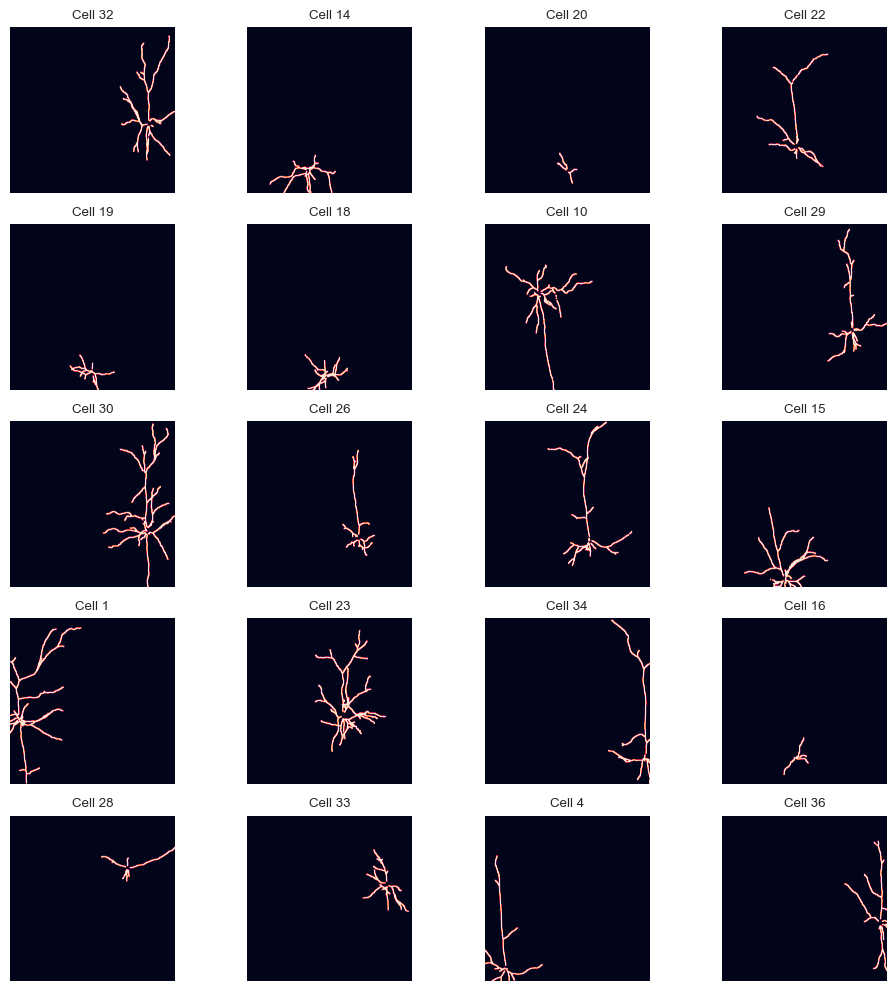

In [133]:
fig,ax = plt.subplots(5,4,figsize=(10,10))
for i,(k,v) in enumerate(single_gt_cvt.items()):
    ax[i//4,i%4].imshow(v.max(axis=0))
    ax[i//4,i%4].set_title(k)
    ax[i//4,i%4].axis('off')
plt.tight_layout()
plt.show();

In [142]:
gt_crops_cvt = {}
qdye_crops_cvt = {}
imaris_crops_cvt = {}

for n in tqdm(range(len(neurons))):
    cell_id = neurons[n]
    gt = single_gt_cvt[cell_id]
    qdye = single_qdye[cell_id]
    imaris = single_autotraces[cell_id]
    gt_crop,bbox = crop_img(gt)
    qdye_crop,_ = crop_img(qdye,bbox=bbox)
    imaris_crop,_ = crop_img(imaris,bbox=bbox)
    gt_crops_cvt[cell_id] = gt_crop
    qdye_crops_cvt[cell_id] = qdye_crop
    imaris_crops_cvt[cell_id] = imaris_crop

  0%|          | 0/20 [00:00<?, ?it/s]

In [145]:
intersection_imaris_gt_cvt = {}

for n in tqdm(range(len(neurons)), desc='Calculating Intersection...'):
    cell_id = neurons[n]
    pred = single_autotraces[cell_id]
    gt = single_gt_cvt[cell_id]
    intersection, union, iou_score = iou(pred, gt)
    intersection_imaris_gt_cvt[cell_id] = intersection

Calculating Intersection...:   0%|          | 0/20 [00:00<?, ?it/s]

In [146]:
intersection_qdye_gt_cvt = {}

for n in tqdm(range(len(neurons)), desc='Calculating Intersection...'):
    cell_id = neurons[n]
    pred = single_qdye[cell_id]
    gt = single_gt_cvt[cell_id]
    intersection, union, iou_score = iou(pred, gt)
    intersection_qdye_gt_cvt[cell_id] = intersection


Calculating Intersection...:   0%|          | 0/20 [00:00<?, ?it/s]

In [148]:
#calculate the overlap percentage
perc_overlap_imaris_gt_cvt = {}
for n in range(len(neurons)):
    cell_id = neurons[n]
    intersection = intersection_imaris_gt_cvt[cell_id]
    gt = single_gt_cvt[cell_id]
    perc_overlap_imaris_gt_cvt[cell_id] = np.sum(intersection)/np.sum(gt)

In [149]:
perc_overlap_qdye_gt_cvt = {}
for n in range(len(neurons)):
    cell_id = neurons[n]
    intersection = intersection_qdye_gt_cvt[cell_id]
    gt = single_gt_cvt[cell_id]
    perc_overlap_qdye_gt_cvt[cell_id] = np.sum(intersection)/np.sum(gt)

In [152]:
import plotly_express as px 

In [253]:
#plot the overlap percentage for the two groups-plotly
df = pd.DataFrame({'Neuron':neurons,'QDye-GT':list(perc_overlap_qdye_gt_cvt.values()),'Imaris-GT':list(perc_overlap_imaris_gt_cvt.values())})
df = pd.melt(df,id_vars='Neuron',var_name='Group',value_name='Overlap Percentage')
#fig = px.box(df,y='Group',x='Overlap Percentage',color='Group',points='all',hover_data=['Neuron'],title='Overlap Percentage between Imaris and QDye with GT',height=500,width=800,template='seaborn')
##remove the background color
#fig.update_layout(plot_bgcolor='white')
##show a frame around the plot
#fig.update_layout(showlegend=True)
#fig.update_traces(boxmean=True)
#fig.show();

In [169]:
df.head(30)

,Neuron,Group,Overlap Percentage
0,Cell 32,Imaris-GT,0.146006
1,Cell 14,Imaris-GT,0.396580
2,Cell 20,Imaris-GT,0.361137
3,Cell 22,Imaris-GT,0.524885
4,Cell 19,Imaris-GT,0.183789
5,Cell 18,Imaris-GT,0.360969
6,Cell 10,Imaris-GT,0.224725
7,Cell 29,Imaris-GT,0.489730
8,Cell 30,Imaris-GT,0.073186
9,Cell 26,Imaris-GT,0.368038


In [170]:
#perform non-parametric test to compare the two groups
#Groups: Imaris-GT and QDye-GT
from scipy import stats
imaris_gt = list(perc_overlap_imaris_gt_cvt.values())
qdye_gt = list(perc_overlap_qdye_gt_cvt.values())

statistic,p_value = stats.mannwhitneyu(imaris_gt,qdye_gt)
print(f'Mann-Whitney U test statistic: {statistic}, p-value: {p_value}')

Mann-Whitney U test statistic: 3.0, p-value: 1.0645689837502488e-07


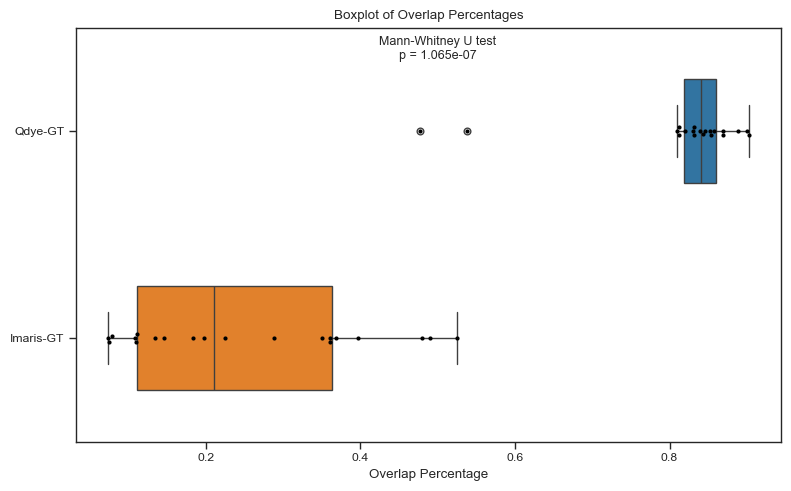

In [242]:
fig, ax = plt.subplots(figsize=(8, 5))

# Create the boxplot
#flierprops = dict(marker='o', markerfacecolor='red', markersize=5, linestyle='none')
bp = sns.boxplot(data=[qdye_gt,imaris_gt], ax=ax, palette=["#1f77b4", "#ff7f0e"],width=0.5,orient='h',fill=True)

# Plot the individual data points using swarmplot
sns.swarmplot(data=[qdye_gt,imaris_gt], ax=ax, color='black', size=3,orient='h')

# Set the labels and title
ax.set_yticklabels(['Qdye-GT', 'Imaris-GT'])
ax.set_xlabel('Overlap Percentage')
ax.set_title('Boxplot of Overlap Percentages')

# Add the Mann-Whitney U test result as text
if p_value < 0.001:
    significance = '***'
elif p_value < 0.01:
    significance = '**'
elif p_value < 0.05:
    significance = '*'
else:
    significance = 'ns'

# Add the Mann-Whitney U test result as text outside the plot
ax.text(0.5,-0.4, f'Mann-Whitney U test\np = {p_value:.3e}', ha='center', va='center', fontsize=9)

# Adjust the spacing and display the plot
fig.tight_layout()
plt.show()

In [265]:
#With plotly for adding to the final report
df = pd.DataFrame({'Neuron':neurons,'QDye-GT':list(perc_overlap_qdye_gt_cvt.values()),'Imaris-GT':list(perc_overlap_imaris_gt_cvt.values())})
df = pd.melt(df,id_vars='Neuron',var_name='Group',value_name='Overlap Percentage')
fig = px.box(df,y='Group',x='Overlap Percentage',color='Group',points='all',hover_data=['Neuron'],title='Overlap Percentage between Imaris and QDye with GT',height=500,width=800,template='seaborn')
#remove the background color
fig.update_layout(plot_bgcolor='white')
#show a frame around the plot
fig.update_layout(showlegend=True)
fig.update_traces(boxmean=True)
#show the statistical test result
fig.update_layout( title_font_family="Arial",legend_title_font_family="Arial")
fig.update_xaxes(title_font_family="Arial")
fig.update_yaxes(title_font_family="Arial")
fig.show();

In [ ]:
import plotly.io as pio
fig.write_image("fig1.eps")

In [269]:
! pip install -U kaleido

In [271]:
df.head()

,Neuron,Group,Overlap Percentage
0,Cell 32,QDye-GT,0.846311
1,Cell 14,QDye-GT,0.852526
2,Cell 20,QDye-GT,0.869020
3,Cell 22,QDye-GT,0.888857
4,Cell 19,QDye-GT,0.842805


In [272]:
df.to_csv('overlap_percentage.csv',index=False)

In [274]:
perc_overlap_imaris_gt_cvt

{'Cell 32': 0.14600619179764712,
 'Cell 14': 0.3965803182893421,
 'Cell 20': 0.3611365622514734,
 'Cell 22': 0.5248850767025839,
 'Cell 19': 0.1837885863600593,
 'Cell 18': 0.36096942167914803,
 'Cell 10': 0.22472504483900216,
 'Cell 29': 0.4897301071957156,
 'Cell 30': 0.07318591424521137,
 'Cell 26': 0.368038299705132,
 'Cell 24': 0.11000892638453041,
 'Cell 15': 0.07789935405057037,
 'Cell 1': 0.19726070447274813,
 'Cell 23': 0.47976560243856486,
 'Cell 34': 0.34980358057320793,
 'Cell 16': 0.2884484186486003,
 'Cell 28': 0.10757819272237092,
 'Cell 33': 0.07446806046036429,
 'Cell 4': 0.13352670995513977,
 'Cell 36': 0.11026730490707345}

In [275]:
import pickle
with open('overlap_percentage_imaris_gt.pkl','wb') as f:
    pickle.dump(perc_overlap_imaris_gt_cvt,f)

with open('overlap_percentage_qdye_gt.pkl','wb') as f:
    pickle.dump(perc_overlap_qdye_gt_cvt,f)